In [2]:
import torch  # PyTorch library
import torchvision.transforms as transforms  # transforms from torchvision for data preprocessing
import torchvision.datasets as datasets  # datasets from torchvision for loading data
from torch.utils.data import DataLoader  # DataLoader from PyTorch for batching and shuffling data
import matplotlib.pyplot as plt  # matplotlib for data visualization
from torch import nn

In [16]:
train_dir = "Training"  # Directory path for training data
test_dir = "Testing"  # Directory path for testing data

basic_transform = transforms.Compose([
    transforms.Resize([512, 512]),
    transforms.ToTensor()  # Convert images to PyTorch tensors
])

In [17]:
# Load datasets with basic transformations
train_dataset = datasets.ImageFolder(root=train_dir, transform=basic_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=basic_transform)

torch.Size([3, 512, 512])


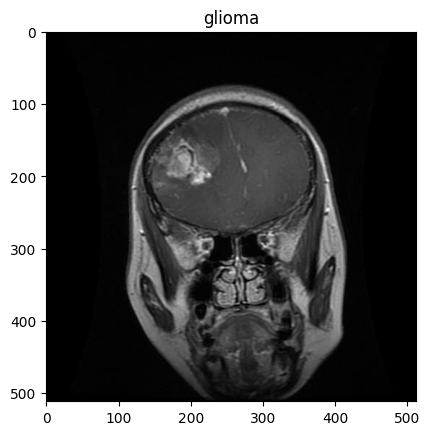

In [18]:
# Plot the first image as a sample
sample_img, sample_cls = train_dataset[0]
plt.imshow(sample_img.numpy().transpose(1, 2, 0))
# Add the title to indicate the class
plt.title(train_dataset.classes[sample_cls])
print(sample_img.shape)

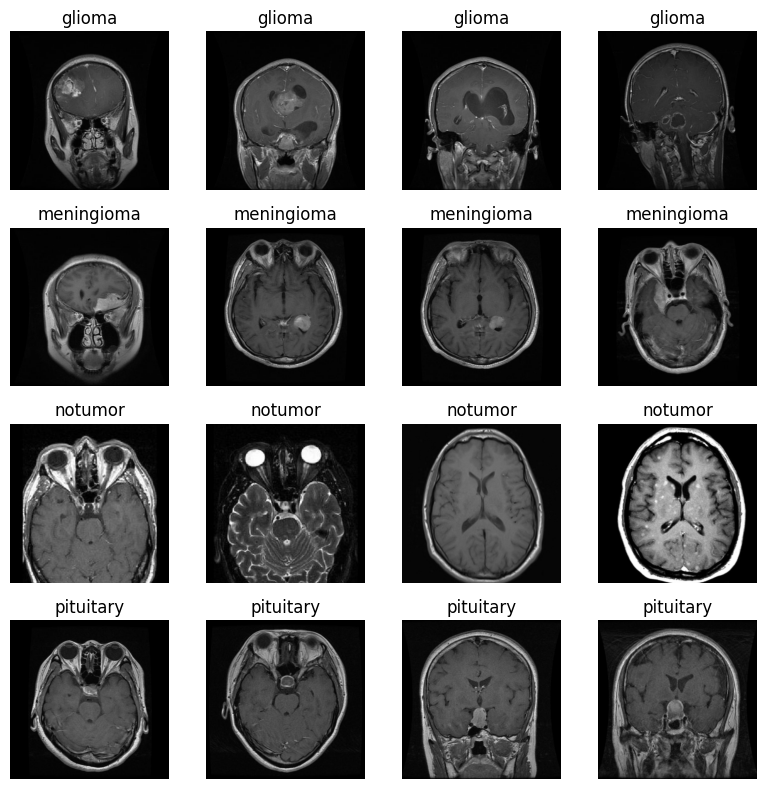

In [20]:
iterable_dataset = iter(train_dataset)
i = 0
sample_dict = {}
count_dict = {} 
plt.figure(figsize=(8, 8))

# Iterate through the dataset, count samples for each class, 
# and display up to 4 images per class
while True:
    try:
        im, cls = next(iterable_dataset)
        count_dict.setdefault(cls, 0)
        count_dict[cls] += 1
    except StopIteration:
        break

    sample_dict.setdefault(cls, 0)
    if sample_dict[cls] >= 4:
        continue

    sample_dict[cls] += 1
    i += 1
    plt.subplot(4, 4, i)
    plt.imshow(im.numpy().transpose(1, 2, 0))
    plt.title(train_dataset.classes[cls])
    plt.axis("off")

plt.tight_layout()

Text(0.5, 1.0, 'Frequency Distribution of classes')

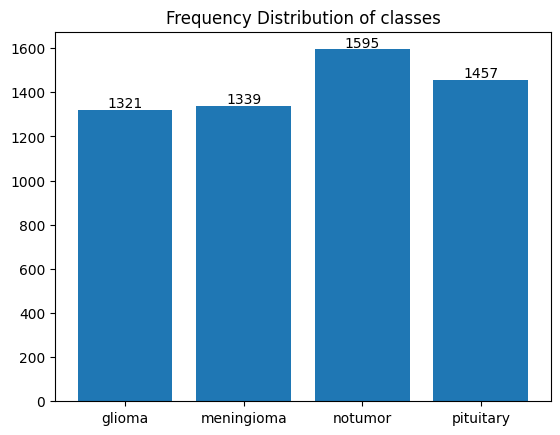

In [21]:
# Make a bar plot to indicate the frequency distribution
plt.bar(train_dataset.classes, count_dict.values())
for i, val in count_dict.items():
    plt.text(i, val + 10, val, ha="center")

plt.title("Frequency Distribution of classes")

In [22]:
# Create dataloaders with a batch size of 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [23]:
print(f"Training samples: {len(train_dataset)}, Training batches: {len(train_loader)}")
print(f"Testing samples: {len(test_dataset)}, Testing batches: {len(test_loader)}")

Training samples: 5712, Training batches: 179
Testing samples: 1311, Testing batches: 41


### Augmentation

In [25]:
general_transforms = {
    'train': transforms.Compose([
        # Data augmentation and transformation for training set
        transforms.Resize((512, 512)),  # Resize images to 512x512
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.RandomRotation(10),  # Randomly rotate images
        transforms.RandomResizedCrop(256, scale=(0.8, 1)),  # Randomly crop and resize images
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        # Transformation for testing set
        transforms.Resize((512, 512)),  # Resize images to 512x512
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets with the defined transformations
train_dataset1 = datasets.ImageFolder(root=train_dir, transform=general_transforms['train'])
test_dataset1 = datasets.ImageFolder(root=test_dir, transform=general_transforms['test'])

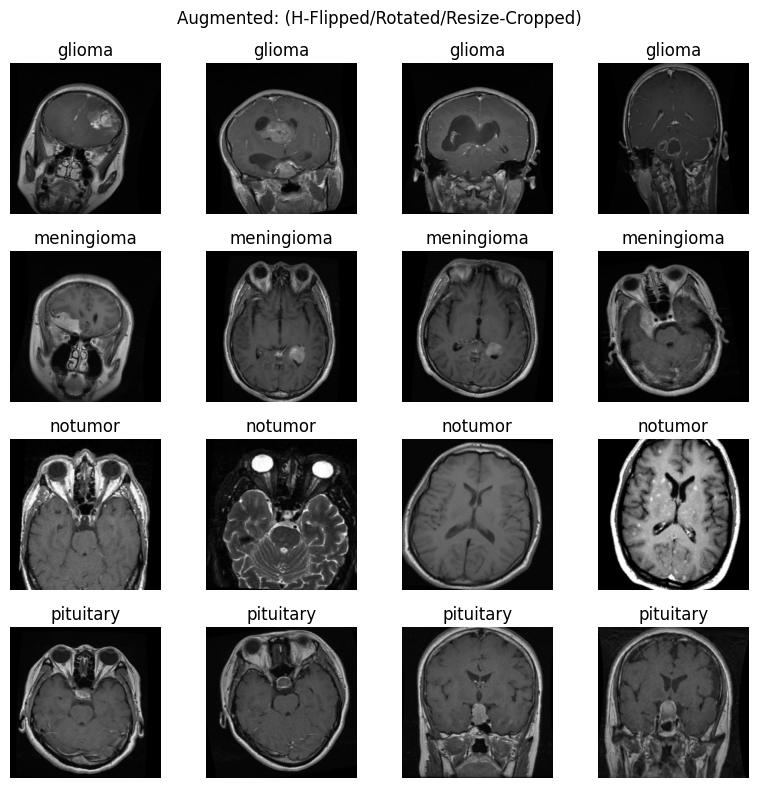

In [26]:
iterable_dataset = iter(train_dataset1)
i = 0
sample_dict = {}
count_dict = {} 
plt.figure(figsize=(8, 8))
while True:
    try:
        im, cls = next(iterable_dataset)
        count_dict.setdefault(cls, 0)
        count_dict[cls] += 1
    except StopIteration:
        break

    sample_dict.setdefault(cls, 0)
    if sample_dict[cls] >= 4:
        continue

    sample_dict[cls] += 1
    i += 1
    plt.subplot(4, 4, i)
    plt.imshow(im.numpy().transpose(1, 2, 0))
    plt.title(train_dataset1.classes[cls])
    plt.axis("off")

plt.suptitle("Augmented: (H-Flipped/Rotated/Resize-Cropped)")
plt.tight_layout()

### GAN

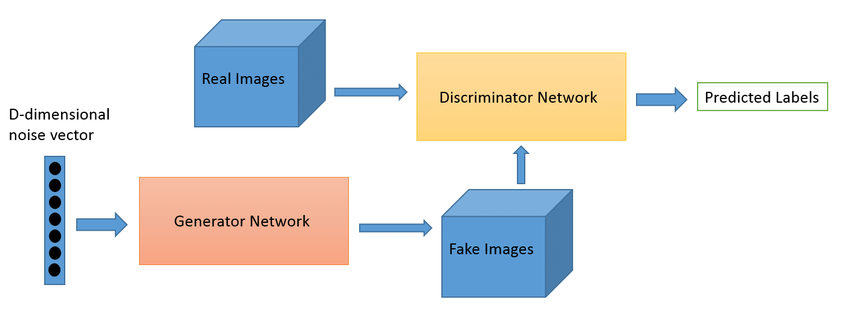

([Credits](https://www.researchgate.net/publication/338050169/figure/fig5/AS:849390331777024@1579521844061/The-general-architecture-of-GAN.ppm))

In [27]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512 * 8, 4, 1, 0, bias=False),  # 4x4
            nn.BatchNorm2d(512 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(512 * 8, 512 * 4, 4, 2, 1, bias=False),  # 8x8
            nn.BatchNorm2d(512 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(512 * 4, 512 * 2, 4, 2, 1, bias=False),  # 16x16
            nn.BatchNorm2d(512 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(512 * 2, 512, 4, 2, 1, bias=False),  # 32x32
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),  # 64x64
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # 128x128
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),  # 256x256
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),  # 512x512
            nn.Tanh()  # Output in the range [-1, 1]
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),  # 256x256
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),  # 128x128
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),  # 64x64
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),  # 32x32
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512 * 2, 4, 2, 1, bias=False),  # 16x16
            nn.BatchNorm2d(512 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512 * 2, 512 * 4, 4, 2, 1, bias=False),  # 8x8
            nn.BatchNorm2d(512 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512 * 4, 512 * 8, 4, 2, 1, bias=False),  # 4x4
            nn.BatchNorm2d(512 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512 * 8, 1, 4, 1, 0, bias=False),  # 1x1
            nn.Sigmoid()  # Output in the range [0, 1]
        )

    def forward(self, input):
        return self.main(input).view(-1)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set the device to GPU if available, otherwise use CPU
netG = Generator().to(device)  # Move the Generator model to the selected device
netD = Discriminator().to(device)  # Move the Discriminator model to the selected device

print(f"Using device: {device}")  # Print the device being used

Using device: cpu


In [29]:
from torch import optim

criterion = nn.BCELoss()  # Binary Cross-Entropy loss function
lr = 0.0001  # Learning rate for the optimizers
optimizerD = optim.Adam(netD.parameters(), lr=lr)  # Adam optimizer for the Discriminator
optimizerG = optim.Adam(netG.parameters(), lr=lr)  # Adam optimizer for the Generator

In [31]:
import torchvision.utils as vutils

num_epochs = 10
nz = 100

# Training loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        # Step 1: Update D network

        ## Train with real images
        netD.zero_grad()
        real_images = real_images.to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float, device=device)
        output = netD(real_images)
        errD_real = criterion(output, label)
        errD_real.backward()

        ## Train with fake images
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(0)
        output = netD(fake_images.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()
        errD = errD_real + errD_fake

        # Step 2: Update G network
        netG.zero_grad()
        label.fill_(1)
        output = netD(fake_images)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

        # Print training stats
        if i % 100 == 0:
            print(f'Epoch [{epoch}/{num_epochs}] Batch {i}/{len(train_loader)} \
                  Loss D: {errD.item():.4f}, Loss G: {errG.item():.4f}')

    # Save images every 10 epochs
    # if epoch % 10 == 0:
    #     with torch.no_grad():
    #         fake = netG(noise).detach().cpu()
    #     vutils.save_image(fake, f'output/fake_images_epoch_{epoch}.png', normalize=True)

# # Save the trained models
# torch.save(netG.state_dict(), 'generator.pth')
# torch.save(netD.state_dict(), 'discriminator.pth')

Epoch [0/10] Batch 0/179                   Loss D: 1.4216, Loss G: 22.9935


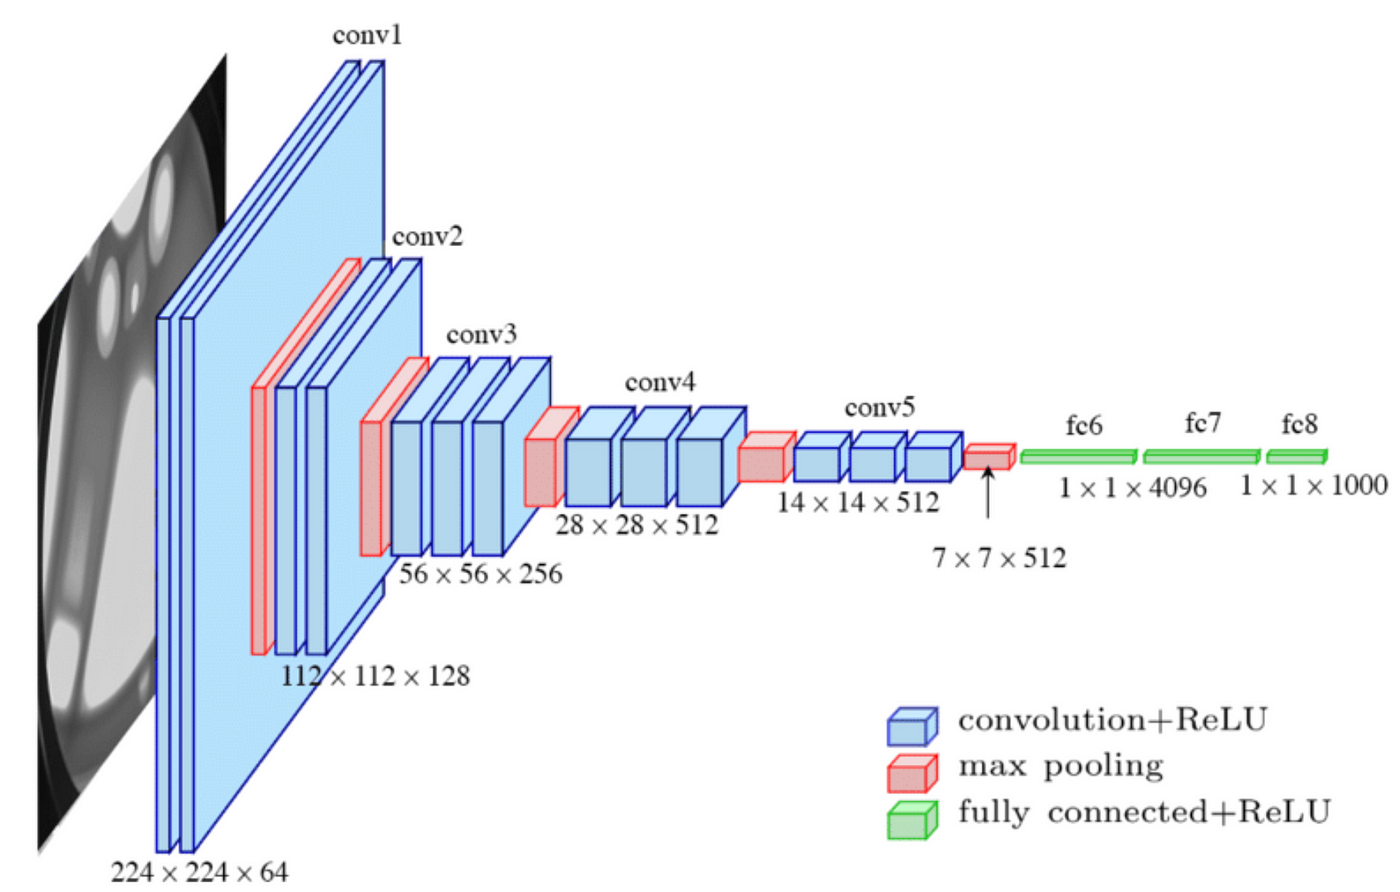

([Credits](https://www.google.com/url?sa=i&url=https%3A%2F%2Flekhuyen.medium.com%2Fan-overview-of-vgg16-and-nin-models-96e4bf398484&psig=AOvVaw03WeTMJ-5pIsqZClDBsrAp&ust=1720557631285000&source=images&cd=vfe&opi=89978449&ved=0CBEQjRxqFwoTCMjNqeammIcDFQAAAAAdAAAAABAE))

In [3]:

class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            # Convolutional Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Convolutional Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Convolutional Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Convolutional Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Convolutional Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            # 512 -> Conv Block 1: 256 -> Conv Block 2: 128 -> Conv Block 3: 64
            # -> Conv Block 4: 32 -> Conv Block 5: 16
            # we end up with 16x16 images after conv block 5.
            nn.Linear(512 * 16 * 16, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Instantiate the model
num_classes = 4  # 4 different types of tumors
vgg_model = VGG16(num_classes)
print(vgg_model)

VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation